In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df_imputed = pd.read_excel('train_imputed.xlsx')
df_imputed.set_index('dt', inplace=True)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400 entries, 2015-01-05 to 2022-08-29
Columns: 151 entries, Цена на арматуру to rolling_mean_4
dtypes: float64(136), int64(15)
memory usage: 475.0 KB


MSE (Среднеквадратичная ошибка): 134626272.0
MAE (Средняя абсолютная ошибка): 9158.46875
Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Лучший MSE: 137453600.0
Лучший MAE: 9252.732421875


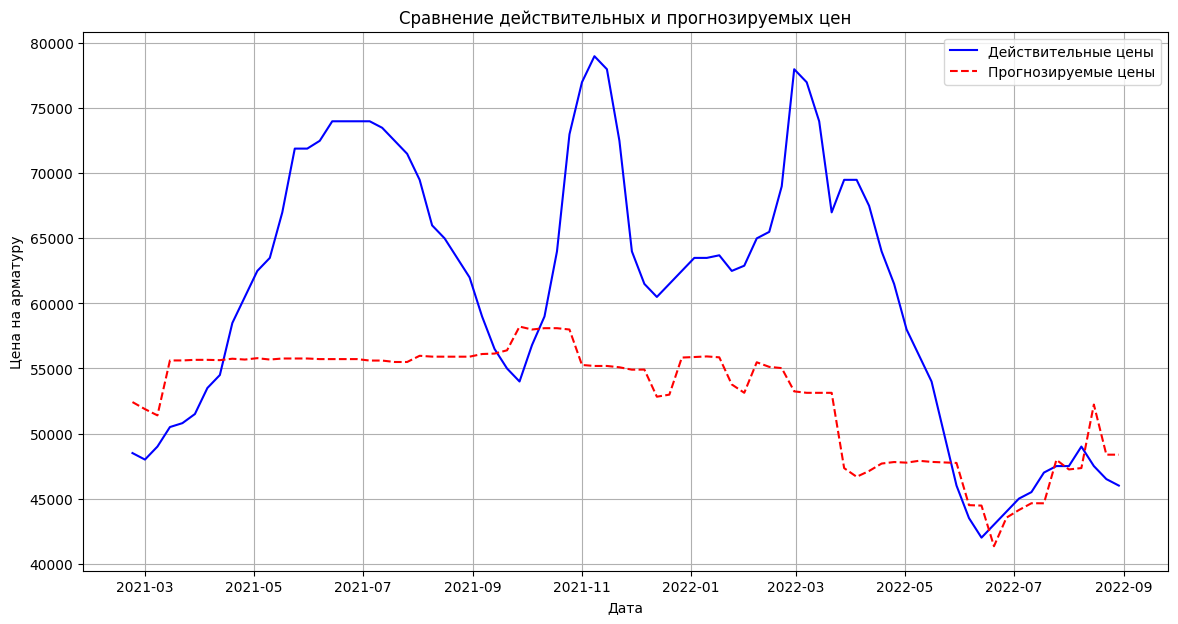

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Предположим, что ваш DataFrame называется df_imputed и содержит подготовленные данные
# Убедитесь, что индекс отсортирован по времени, если это временной ряд
# Например: df_imputed = pd.read_csv('ваш_файл.csv', index_col='date', parse_dates=True)

# Определите целевую переменную и признаки
target = 'Цена на арматуру'  # Замените на вашу целевую переменную
features = [col for col in df_imputed.columns if col != target]  # Все столбцы, кроме целевой переменной

# Разделите данные на обучающую и тестовую выборки
# Для временных рядов важно сохранять порядок, поэтому не используем shuffle
train_size = int(len(df_imputed) * 0.8)  # 80% на обучение, 20% на тест
train, test = df_imputed.iloc[:train_size], df_imputed.iloc[train_size:]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Создайте и обучите модель XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror',  # Для регрессии с квадратичной ошибкой
                         n_estimators=100,             # Количество деревьев
                         learning_rate=0.1,            # Скорость обучения
                         max_depth=3)                  # Максимальная глубина деревьев
model.fit(X_train, y_train)

# Сделайте прогнозы на тестовой выборке
predictions = model.predict(X_test)

# Оцените производительность модели
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f'MSE (Среднеквадратичная ошибка): {mse}')
print(f'MAE (Средняя абсолютная ошибка): {mae}')

# (Опционально) Настройка гиперпараметров с помощью GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],    # Пробуем разные количества деревьев
    'learning_rate': [0.01, 0.1, 0.2], # Разные скорости обучения
    'max_depth': [3, 5, 7]             # Разные глубины деревьев
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                           param_grid=param_grid,
                           cv=3,                   # 3-кратная кросс-валидация
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Выведите лучшие параметры и обучите модель с ними
print(f'Лучшие параметры: {grid_search.best_params_}')
best_model = grid_search.best_estimator_
best_predictions = best_model.predict(X_test)

# Оцените улучшенную модель
best_mse = mean_squared_error(y_test, best_predictions)
best_mae = mean_absolute_error(y_test, best_predictions)
print(f'Лучший MSE: {best_mse}')
print(f'Лучший MAE: {best_mae}')

# Постройте график действительных и прогнозируемых цен
plt.figure(figsize=(14, 7))  # Установите размер графика
plt.plot(test.index, y_test, label='Действительные цены', color='blue')  # Линия действительных значений
plt.plot(test.index, best_predictions, label='Прогнозируемые цены', color='red', linestyle='--')  # Линия прогнозов
plt.xlabel('Дата')  # Подпись оси X
plt.ylabel('Цена на арматуру')  # Подпись оси Y
plt.title('Сравнение действительных и прогнозируемых цен')  # Заголовок графика
plt.legend()  # Легенда
plt.grid(True)  # Сетка для читаемости
plt.show()  # Отобразить график